In [1]:
import os
import astropy.io.fits as fits
import numpy as np
import scipy
import scipy.ndimage as ndi
import matplotlib.pylab as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pyklip.klip
import pyklip.instruments.Instrument as Instrument
import pyklip.parallelized as parallelized
import pyklip.rdi as rdi
import pyklip.fakes as fakes

In [2]:
#Import the dataset to be used
filtername = "f300m"

# read in roll 1
with fits.open("../old_simulated_data/NIRCam_target_Roll1_{0}.fits".format(filtername)) as hdulist:
    roll1_cube = hdulist[0].data

# read in roll 2
with fits.open("../old_simulated_data/NIRCam_target_Roll2_{0}.fits".format(filtername)) as hdulist:
    roll2_cube = hdulist[0].data  

# combine the two rows
full_seq = np.concatenate([roll1_cube, roll2_cube], axis=0)

# two rolls are offset 10 degrees
pas = np.append([0 for _ in range(roll1_cube.shape[0])], [10 for _ in range(roll2_cube.shape[0])])

# for each image, the (x,y) center where the star is is just the center of the image
centers = np.array([np.array(frame.shape)/2. for frame in full_seq])

# give it some names, just in case we want to refer to them
filenames = np.append(["roll1_{0}".format(i) for i in range(roll1_cube.shape[0])],
                      ["roll2_{0}".format(i) for i in range(roll1_cube.shape[0])])

#Define dataset
dataset = Instrument.GenericData(full_seq, centers, IWA=4, parangs=pas, filenames=filenames)
dataset.flipx = False

In [3]:
# read in unocculted PSF
with fits.open("../old_simulated_data/NIRCam_unocculted_f300m.fits".format(filtername)) as hdulist:
    psf_cube = hdulist[0].data 
    print(psf_cube.shape)  
    
# collapse reference psf in time
psf_frame = np.nanmean(psf_cube, axis=0)

# find the centroid
bestfit = fakes.gaussfit2d(psf_frame, 71, 30, searchrad=3, guessfwhm=2, guesspeak=1, refinefit=True)

psf_xcen, psf_ycen = bestfit[2:4]
print(psf_xcen, psf_ycen)

# recenter PSF to that location
x, y = np.meshgrid(np.arange(-20,20.1,1), np.arange(-20,20.1,1))
x += psf_xcen
y += psf_ycen

psf_stamp = scipy.ndimage.map_coordinates(psf_frame, [y,x])
print(psf_stamp.shape)

(6, 101, 101)
70.45855749153525 29.8360856033007
(41, 41)


In [4]:
#Need to uncollapse the reference psf.  
psf_stamp = np.expand_dims(psf_stamp, axis=0)

In [5]:
#Specify the desired contrasts of the fake planets' flux
input_contrasts = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2]
planet_seps = [15,20,25,30,35,40]
planet_fwhm = 3.5


#Defining angle of injected fakes in CCW angle from +x axis to +y axis
thetas = [np.ones(12)*30.0, np.ones(12)*60.0, np.ones(12)*90.0, np.ones(12)*150.0, np.ones(12)*180.0, np.ones(12)*210.0]
thetas = thetas+dataset.PAs
thetas

array([[ 30.,  30.,  30.,  30.,  30.,  30.,  40.,  40.,  40.,  40.,  40.,
         40.],
       [ 60.,  60.,  60.,  60.,  60.,  60.,  70.,  70.,  70.,  70.,  70.,
         70.],
       [ 90.,  90.,  90.,  90.,  90.,  90., 100., 100., 100., 100., 100.,
        100.],
       [150., 150., 150., 150., 150., 150., 160., 160., 160., 160., 160.,
        160.],
       [180., 180., 180., 180., 180., 180., 190., 190., 190., 190., 190.,
        190.],
       [210., 210., 210., 210., 210., 210., 220., 220., 220., 220., 220.,
        220.]])

In [6]:
#Inject fakes
#Attempting to inject one fake at each theta in a spiral.

#for input_contrast, planet_sep in zip(input_contrasts, planet_seps):
#Multiply unocculted psf by desired contrast level to simulate planet psf
   # planet_fluxes = y*input_contrast


    #for theta in thetas:
     #   fakes.inject_planet(frames = dataset.input, 
      #                      centers=dataset.centers, 
       #                     inputflux=planet_fluxes, 
        #                    astr_hdrs=dataset.wcs, 
         #                   radius=planet_sep,
          #                  pa = None,
           #                 thetas = theta)

In [7]:
for input_contrast, planet_sep, theta in zip(input_contrasts, planet_seps, thetas):
#Multiply unocculted psf by desired contrast level to simulate planet psf
    planet_fluxes = psf_stamp*input_contrast

    fakes.inject_planet(frames = dataset.input, 
                        centers=dataset.centers, 
                        inputflux=planet_fluxes, 
                        astr_hdrs=dataset.wcs, 
                        radius=planet_sep,
                        pa = None,
                        thetas = theta)

In [8]:
#Set output directory
outputdir = 'contrast_tests'
fileprefix = 'FAKE_KLIP_ADI_A9K5S4M1'
numbasis = [1,5,10,20,50]


#Run KLIP on dataset with injected fakes
parallelized.klip_dataset(dataset, 
                          outputdir=outputdir, 
                          fileprefix=fileprefix, 
                          algo = 'klip', 
                          annuli=9, 
                          subsections=4, 
                          movement=1, 
                          numbasis=numbasis, 
                          mode="ADI")

Begin align and scale images for each wavelength
Wavelength 1.0 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 36
27.78% done (9/36 completed)
55.56% done (19/36 completed)
83.33% done (29/36 completed)
Closing threadpool
Derotating Images...
Writing Images to directory /Users/samuelsetegne/JWST-ERS-Pipeline/notebooks/thetas_tests/contrast_tests


/Users/samuelsetegne/pyklip/pyklip/parallelized.py:1561: RuntimeWarning: Mean of empty slice
  KLmode_cube = np.nanmean(pixel_weights * dataset.output, axis=(1,2))


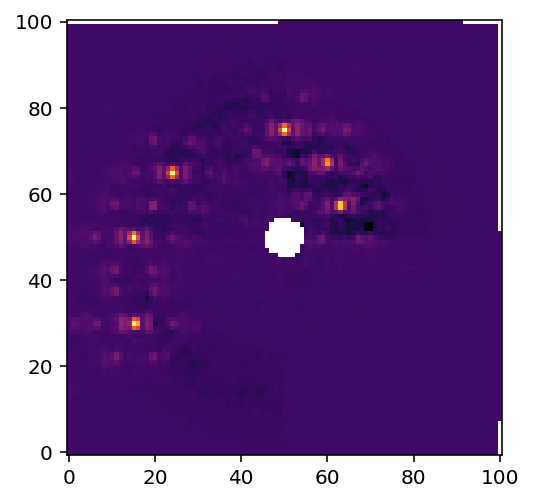

In [9]:
# Open the fits file created
with fits.open("contrast_tests/FAKE_KLIP_ADI_A9K5S4M1-KLmodes-all.fits") as hdulist:
    adi_cube = hdulist[0].data

#Plot the result of KLIP
plt.figure()
# plot the KL20 Cube (index of 3)
plt.imshow(adi_cube[2], interpolation='nearest', cmap = 'inferno')
plt.gca().invert_yaxis()

In [10]:
#Why does thetas + pa's still not do anything?
#Shouldn't seps be different?